# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [19]:
X_train = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/y_test.txt").astype(int)

In [20]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [22]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Определим число уникальных значений меток целевого класса.

In [23]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [24]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [26]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)

X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [27]:
# Ваш код здесь
print(pca.n_components_) 

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [31]:
# Ваш код здесь
first_component_variance_ratio = pca.explained_variance_ratio_[0]

variance_percentage = round(first_component_variance_ratio * 100)

print(f"На первую главную компоненту приходится: {variance_percentage}% дисперсии")


На первую главную компоненту приходится: 51% дисперсии


Визуализируйте данные в проекции на первые две главные компоненты.

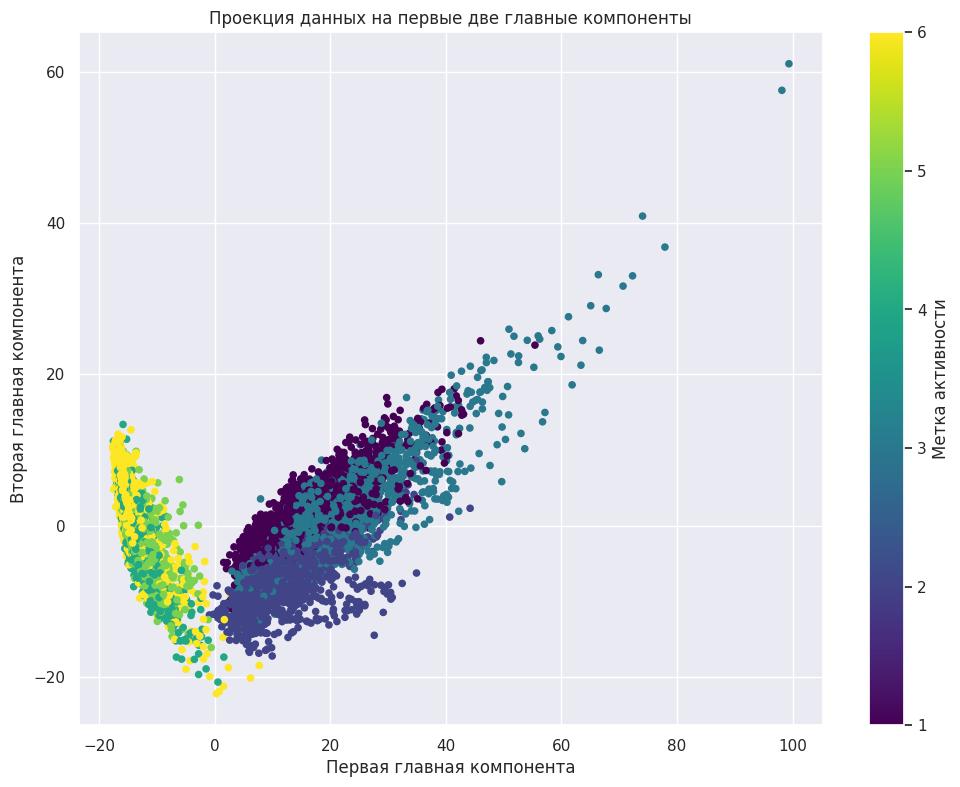

In [34]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')

plt.title('Проекция данных на первые две главные компоненты')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Метка активности')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

Ответ - 2 кластера(ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [36]:
# Ваш код здесь
from sklearn.cluster import KMeans
import numpy as np

n_classes = np.unique(y).shape[0]

kmeans = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)

cluster_labels = kmeans.fit_predict(X_pca)

print(f"Количество кластеров: {n_classes}")
print("Пример предсказанных меток кластеров:", cluster_labels[:15])


Количество кластеров: 6
Пример предсказанных меток кластеров: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

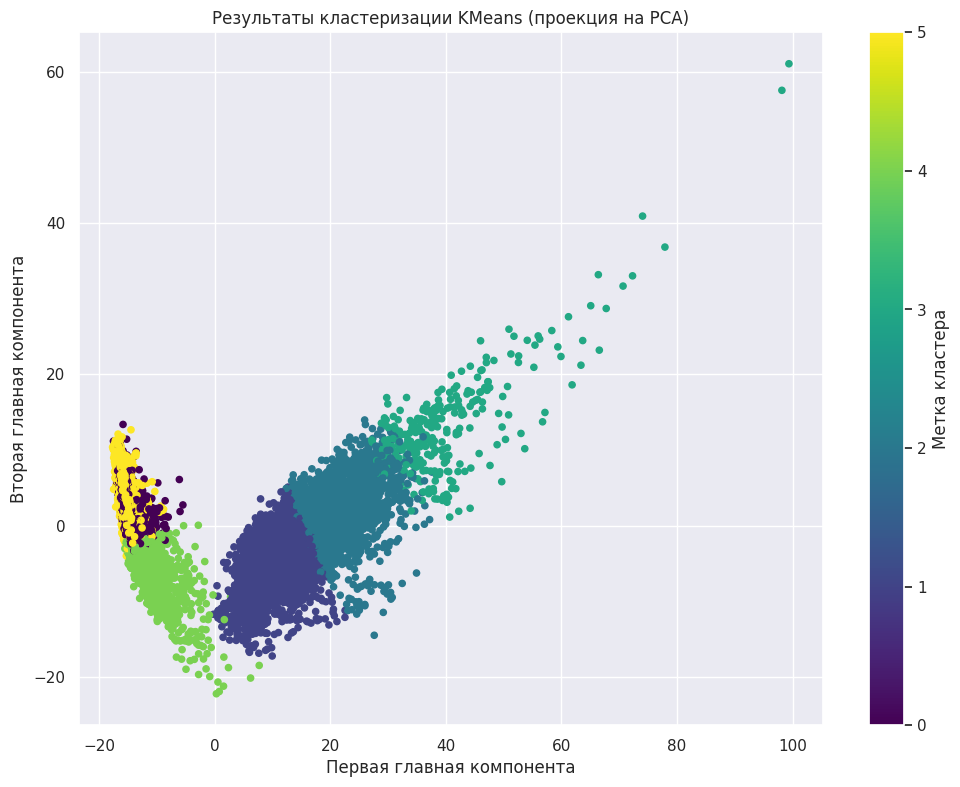

In [37]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')

plt.title('Результаты кластеризации KMeans (проекция на PCA)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Метка кластера')
plt.show()


Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [38]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

In [40]:


contingency_table = pd.crosstab(y, cluster_labels, rownames=['True Label'], colnames=['Cluster Label'])

print("Таблица сопряженности (Истинная метка vs. Метка кластера):")
print(contingency_table)

purity_metric = contingency_table.max(axis=1) / contingency_table.sum(axis=1)

print("\nЗначение метрики для каждого класса:")
activity_names = {
    1: "Ходьба",
    2: "Подъем по лестнице",
    3: "Спуск по лестнице",
    4: "Сидение",
    5: "Стояние",
    6: "Лежание"
}
for i, value in purity_metric.items():
    print(f"- {activity_names[i]}: {value:.2f}")

best_activity_index = purity_metric.idxmax()
print(f"\nЛучше всего отделилась активность: {activity_names[best_activity_index]}")


Таблица сопряженности (Истинная метка vs. Метка кластера):
Cluster Label     0     1    2    3    4     5
True Label                                    
1                 0   903  741   78    0     0
2                 0  1241  296    5    2     0
3                 0   320  890  196    0     0
4              1235     1    0    0  450    91
5              1344     0    0    0  562     0
6                52     5    0    0  329  1558

Значение метрики для каждого класса:
- Ходьба: 0.52
- Подъем по лестнице: 0.80
- Спуск по лестнице: 0.63
- Сидение: 0.69
- Стояние: 0.71
- Лежание: 0.80

Лучше всего отделилась активность: Подъем по лестнице


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.






















100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


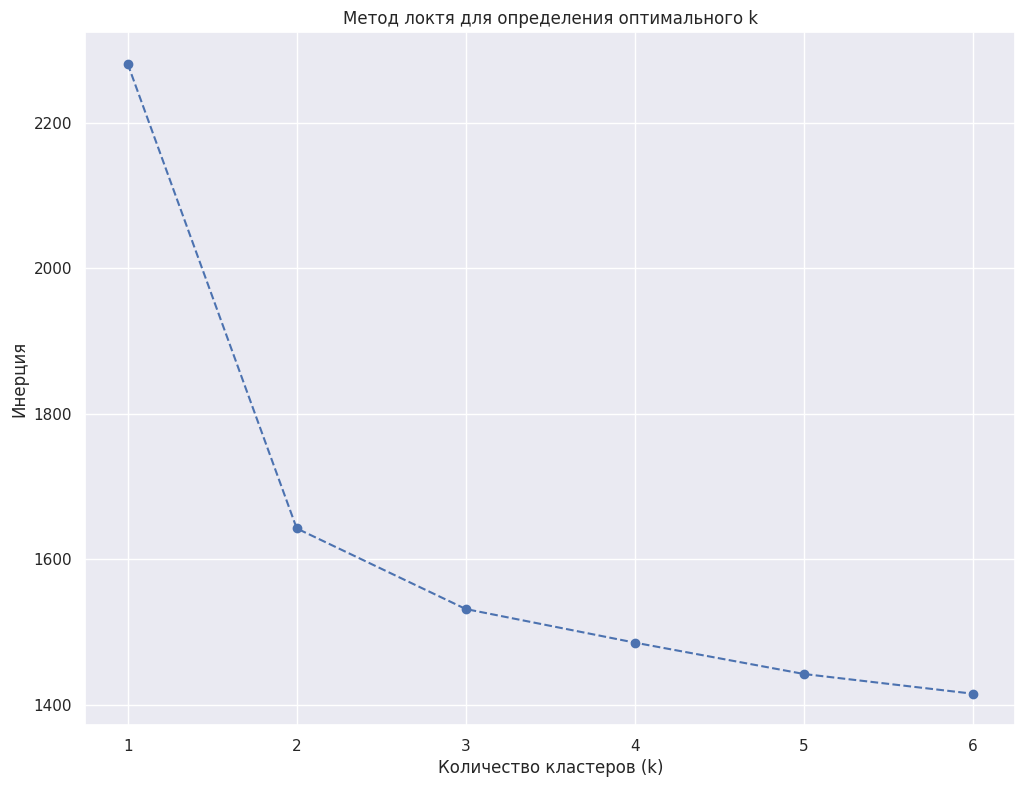

In [45]:
from tqdm import tqdm

inertia = []
for k in tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))
k_range = range(1, n_classes + 1)

# Строим график
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Метод локтя для определения оптимального k')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.xticks(k_range)
plt.grid(True)
plt.show()


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

In [46]:
Ответ: 2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [48]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [49]:
from sklearn.metrics import adjusted_rand_score

ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)


ari_kmeans = adjusted_rand_score(y, cluster_labels)

ari_agg = adjusted_rand_score(y, ag.labels_)

print(f"Adjusted Rand Index для KMeans: {ari_kmeans:.4f}")
print(f"Adjusted Rand Index для Agglomerative Clustering: {ari_agg:.4f}")


Adjusted Rand Index для KMeans: 0.4198
Adjusted Rand Index для Agglomerative Clustering: 0.4936


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Все три утверждения являются верными

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [50]:
# Ваш код здесь
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import numpy as np
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [51]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [53]:
# Ваш код здесь
grid_search = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,estimator,LinearSVC(random_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [54]:
# Ваш код здесь
print(f"\nЛучший параметр C: {grid_search.best_params_['C']}")
print(f"Лучший результат на кросс-валидации (accuracy): {grid_search.best_score_:.4f}")


Лучший параметр C: 0.1
Лучший результат на кросс-валидации (accuracy): 0.9380


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

Правильный ответ 0.1

In [57]:
y_predicted = grid_search.predict(X_test_scaled)

In [58]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,443,588,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

In [ ]:
from sklearn.metrics import classification_report

activity_names = [
    '1_WALKING', 
    '2_WALKING_UPSTAIRS', 
    '3_WALKING_DOWNSTAIRS', 
    '4_SITTING', 
    '5_STANDING', 
    '6_LAYING'
]

report = classification_report(y_test, y_predicted, target_names=activity_names)

print("Отчет о качестве классификации:")
print(report)


Отчет о качестве классификации:
                      precision    recall  f1-score   support

           1_WALKING       0.97      1.00      0.98       496
  2_WALKING_UPSTAIRS       0.98      0.97      0.98       471
3_WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
           4_SITTING       0.96      0.87      0.91       491
          5_STANDING       0.88      0.97      0.92       532
            6_LAYING       1.00      0.98      0.99       537

            accuracy                           0.96      2947
           macro avg       0.97      0.96      0.96      2947
        weighted avg       0.96      0.96      0.96      2947



Хуже всего по точности — стояние
Хуже всего по полноте — сидение

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [60]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import numpy as np

pca_clf = PCA(n_components=0.9, random_state=RANDOM_STATE)

X_train_pca = pca_clf.fit_transform(X_train_scaled)

X_test_pca = pca_clf.transform(X_test_scaled)

print(f"Размерность обучающей выборки после PCA: {X_train_pca.shape}")
print("-" * 30)


svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
params_grid_pca = {'C': np.logspace(-3, 2, 6)}

grid_search_pca = GridSearchCV(svc_pca, params_grid_pca, cv=3, n_jobs=-1, verbose=1)
grid_search_pca.fit(X_train_pca, y_train)

print("-" * 30)
print("Результаты для данных после PCA:")
print(f"Лучший параметр C: {grid_search_pca.best_params_['C']}")
print(f"Лучшее качество на кросс-валидации: {grid_search_pca.best_score_:.4f}")
print("-" * 30)


accuracy_full_features = grid_search.best_score_

accuracy_pca_features = grid_search_pca.best_score_

difference = accuracy_full_features - accuracy_pca_features
difference_percent = round(difference * 100)

print(f"Качество на всех признаках: {accuracy_full_features:.4f}")
print(f"Качество на PCA-признаках: {accuracy_pca_features:.4f}")
print(f"Разница в качестве: {difference:.4f} или примерно {difference_percent}%")


Размерность обучающей выборки после PCA: (7352, 63)
------------------------------
Fitting 3 folds for each of 6 candidates, totalling 18 fits
------------------------------
Результаты для данных после PCA:
Лучший параметр C: 0.1
Лучшее качество на кросс-валидации: 0.8984
------------------------------
Качество на всех признаках: 0.9380
Качество на PCA-признаках: 0.8984
Разница в качестве: 0.0396 или примерно 4%


Ответ: 4%

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

Ответ: 2 и 3 

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

Запускаем t-SNE... Это может занять несколько минут.
t-SNE завершен.


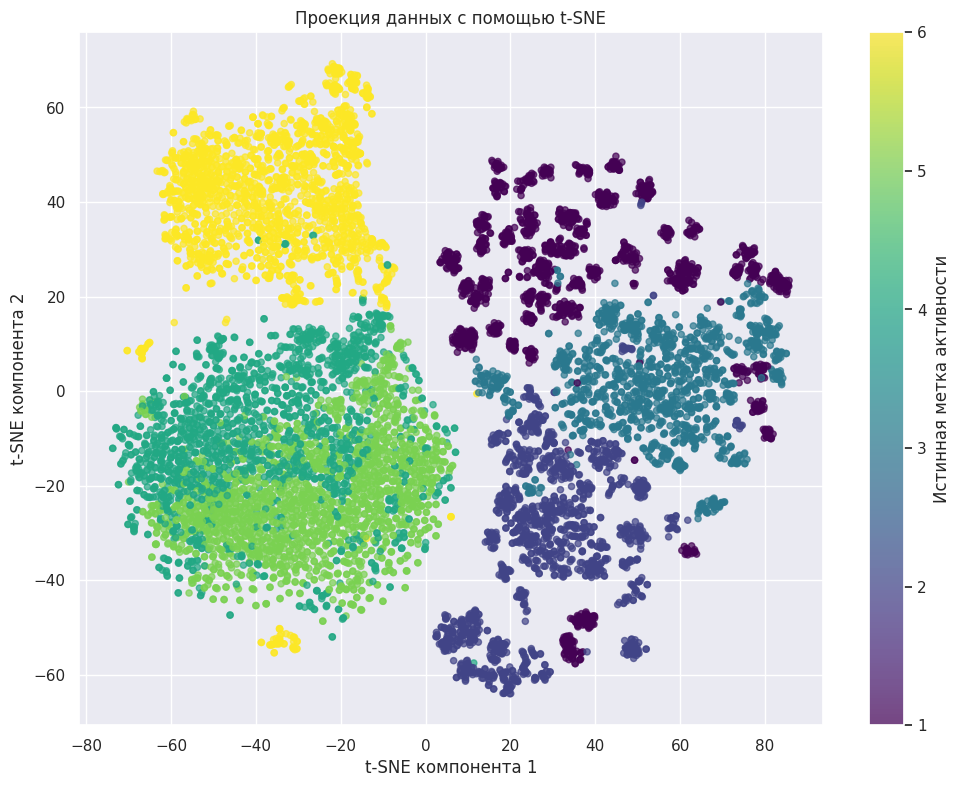

In [ ]:
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

tsne = TSNE(n_components=2, perplexity=50, random_state=RANDOM_STATE, n_jobs=-1)

print("Запускаем t-SNE... Это может занять несколько минут.")
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE завершен.")

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis', alpha=0.7)
plt.title('Проекция данных с помощью t-SNE')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.colorbar(label='Истинная метка активности')
plt.show()


Найдено кластеров: 163
Количество шумовых точек: 3072


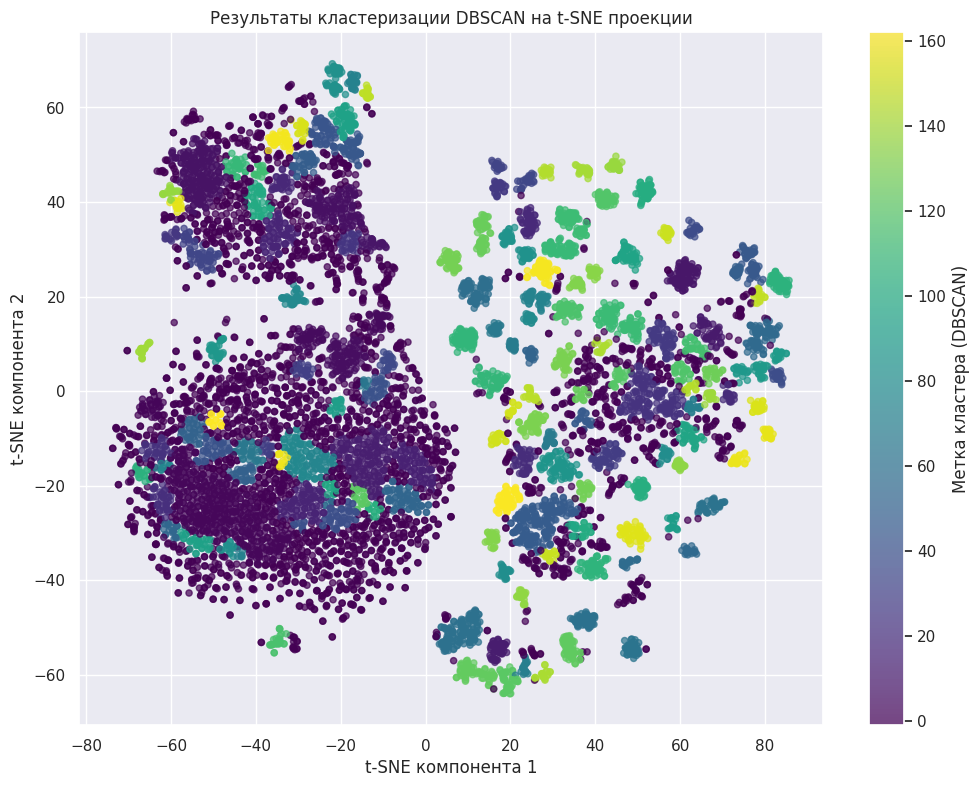


Adjusted Rand Index для DBSCAN: 0.0809


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

dbscan = DBSCAN(eps=1.8, min_samples=15, n_jobs=-1)

dbscan_labels = dbscan.fit_predict(X_tsne)

n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print(f"Найдено кластеров: {n_clusters_}")
print(f"Количество шумовых точек: {n_noise_}")

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=20, cmap='viridis', alpha=0.7)
plt.title('Результаты кластеризации DBSCAN на t-SNE проекции')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.colorbar(label='Метка кластера (DBSCAN)')
plt.show()

ari_dbscan = adjusted_rand_score(y, dbscan_labels)
print(f"\nAdjusted Rand Index для DBSCAN: {ari_dbscan:.4f}")
